In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 9999)
pd.set_option('display.max_rows', 9999)

### Import Trades from file generated by code and create Prices dataframe

In [2]:
# Read generated buys
trades = pd.read_feather('/Users/renovieira/Desktop/trades.feather')
business_days = set(trades['just_date'].unique())

### Create DataFrames of Buys and Sells
#### Buys

In [3]:
def extract_buys(df, list_of_signals, buy_date):
    
    # Create empty list to store results
    buys_list = []
    
    # Columns
    columns_list = ['symbol', 'date', 'price', 'order_type', 'shares', 'total', 'strategy']
    
    # Empty dataframe
    empty_df = pd.DataFrame([[0,0,0,0,0,0]], columns = ['symbol', 'date', 'price', 'order_type', 'shares', 'total'])
    
    # Loop through different strategies
    for buy_signal in list_of_signals:

        # Create dataframe with buys
        buys = df[(df['just_date'] == buy_date) 
                    & (df[buy_signal] == True)
                    & (df['sell_signal?'] != True)][['symbol', 'just_date', 'close_price_x']]

        # Create some other columns
        buys['order_type'] = 'buy'
        buys['shares'] = 100 / buys['close_price_x']
        buys['total'] = buys['shares'] * buys['close_price_x']
        buys['strategy'] = buy_signal
       
        # If length is zero then create empty record
        if len(buys) == 0:
            buys_none = empty_df
            buys_none['strategy'] = buy_signal
            buys_list.append(buys_none.values.tolist()[0])
        
        # Else then append buys
        else:
            buys.columns = columns_list
            buys_list.append(buys.values.tolist()[0])
    
    # Transform list into a Dataframe
    buys_df = pd.DataFrame(buys_list, columns = columns_list)
    
    return buys_df

### Sells

In [4]:
def extract_sells(trades, date):
    # Search for the sell_signal on a given day
    sells = trades[(trades['just_date'] == date) 
                & (trades['sell_signal?'] == True)][['symbol', 'just_date', 'close_price_x']]
    
    # Create Column with order type
    sells['order_type'] = 'sell'
    
    # Rename a columns
    sells.columns = ['symbol', 'sell_date', 'price', 'order_type']
    
    return sells

### Loop Through Days
Logic:
- See if there are any buys on that day and add to holdings_df if that's the case.
- See if there are any sells using the sell_signal and limits (max_loss and max_holdings).
- If you have sells, then remove them from holdings and add to rgl_df.

In [78]:
# Define Min, Max and Moving Dates
min_date = trades['just_date'].min()
max_date = trades['just_date'].max()
number_of_days = (max_date - min_date).days + 1
count = 1

# Result Lists
holdings_list = []
rgl_list = []

# The moving date gives sells/buys on a given day.
moving_date = min_date

# List of buy signals to be analyzed
list_of_signals = ['buy_signal?1', 'buy_signal?2','buy_signal?3','buy_signal?4']

# Max loss and holdings
max_loss = -0.10
max_holdings = 30



# While moving date is less or equal to max_date
while moving_date <= max_date:
    
    # Start tracking time
    start_time = time.time()
    
    # If it's the first date, the process is different, because holdings and rgl need to be created yet
    if moving_date == min_date:
        
        # Figure out buys
        buys = extract_buys(trades, list_of_signals, moving_date)
        
        # Create holdings
        holdings_df = buys[['strategy', 'date', 'symbol', 'price', 'shares', 'total']]
        holdings_df.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis']
        
        # As of Date and close_price columns
        holdings_df['as_of_date'] = moving_date
        holdings_df['day_close_price'] = 0
        
        # Convert symbols to string to avoid merging problems in the future
        holdings_df['symbol'] = holdings_df['symbol'].astype(str)
        
        # Holdings append
        holdings_list.append(holdings_df.values.tolist())
        
        # Create RGL
        rgl_df = holdings_df.copy()
        rgl_list.append(rgl_df.values.tolist())
                
    # If it's not the first day:
    else:
        
        # Create prices dataframe from trades
        prices = trades[trades['just_date'] == moving_date][['symbol', 'close_price_x']]
        prices.columns = ['symbol', 'day_close_price']
        
        # Get Previous Day's Holdings and store the number of securities held on that day
        
        #previous_holdings = temp_holdings[temp_holdings['as_of_date'] == previous_day]
        previous_holdings = pd.DataFrame(holdings_list[-1])
        previous_holdings = previous_holdings.iloc[:,0:6]
        previous_holdings.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares',
                                       'cost_basis']
        #previous_holdings = previous_holdings.drop('day_close_price', axis=1)
        #previous_holdings.drop(['as_of_date'], axis=1, inplace=True)
        number_of_symbols = len(previous_holdings['symbol'].unique())
        
        # Figure out sells and create list of symbols with sell signals
        sells = extract_sells(trades, moving_date)
        sold_symbols = set(sells['symbol'])
        
        # Remove sells from Previous Day's Holdings
        holdings_no_sells = previous_holdings[~previous_holdings['symbol'].isin(sold_symbols)]
        
        # Do the following with the securities that were left (only in business days)
        if moving_date in business_days:
        
            # Create new sell signals based on max_loss and max_holdings
            # Calculate % gain
            stop_loss_sells = pd.merge(holdings_no_sells, prices, on='symbol', how='left')
            stop_loss_sells['market_value'] = stop_loss_sells['shares'] * stop_loss_sells['day_close_price']
            stop_loss_sells['%_gain'] = (stop_loss_sells['market_value'] / stop_loss_sells['cost_basis']) - 1
            
            # Create column with date and remove 0's from sells
            stop_loss_sells['just_date'] = moving_date
            stop_loss_sells = stop_loss_sells[stop_loss_sells['buy_date'] != 0]
            
            # If sell signals were generated from this, then do the following
            if len(stop_loss_sells) > 0:
                
                # Calculate the number of Holding Days, which is the different between buy_date and just_date
                stop_loss_sells['holding_days'] = (stop_loss_sells['just_date'] - stop_loss_sells['buy_date'])
                stop_loss_sells['holding_days'] = stop_loss_sells['holding_days'].dt.days
                
                # Create Sell Signal if % gain is below max_loss OR holding_days is greater then max_holdings
                stop_loss_sells = stop_loss_sells[
                    (stop_loss_sells['%_gain'] < max_loss)
                   |(stop_loss_sells['holding_days'] > max_holdings)][['symbol', 'just_date', 'day_close_price']]
                
                # Create order_type column and rename columns
                stop_loss_sells['order_type'] = 'sell'
                stop_loss_sells.columns = ['symbol', 'sell_date', 'price', 'order_type']

                # Concatenate new sells with sells generated from sell_signal? 
                sells = pd.concat([sells, stop_loss_sells])
                
                # Create list of sold symbols
                sold_symbols = set(sells['symbol'])

            # Remove sells from Previous Day's Holdings, again. This time including sells from loss and holding limits
            holdings_no_sells = previous_holdings[~previous_holdings['symbol'].isin(sold_symbols)]
        
        # Store Realized Gains/Losses in rgl_df only if there are symbols in sold_symbols
        if len(sold_symbols) > 0:
            
            # Create Dataframe by merging Previous Day's Holdings with sells dataframe
            today_rgl = pd.merge(previous_holdings, sells, how='inner', on='symbol')
            
            # Get prices in which the securities were sold
            today_rgl = pd.merge(today_rgl, prices, how='left', on='symbol')
            
            # Create as of date column and calculate gains and market value
            today_rgl['as_of_date'] = moving_date
            today_rgl['market_value'] = today_rgl['shares'] * today_rgl['day_close_price']
            today_rgl['$_gain'] = today_rgl['market_value'] - today_rgl['cost_basis']
            today_rgl['%_gain'] = (today_rgl['market_value'] / today_rgl['cost_basis']) - 1
            
            # Add that into master rgl_df
            #rgl_df = pd.concat([rgl_df, today_rgl])
            if len(today_rgl) > 0:
                rgl_list.append(today_rgl.values.tolist())
        
        # Now that sold securities have been removed from holdings, it's time to look for buys
        buys = extract_buys(trades, list_of_signals, moving_date)
        buys = buys[['strategy', 'date', 'symbol', 'price', 'shares', 'total']]
        buys.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis']
        
        # Add Buys to holdings
        today = pd.concat([holdings_no_sells, buys])
        today = today.drop_duplicates()
        today['as_of_date'] = moving_date
         
        # Number of Symbols in new holdings (Previous Day's minus sells, plus new buys)
        number_of_symbols = len(today['symbol'].unique())
        
        # If you have more than one security (there's a placeholder, so we need more than one)
        # Then pull prices to calculate market value and % gain
        if number_of_symbols > 1:
            today = pd.merge(today, prices, on='symbol', how='left')
            today['market_value'] = today['shares'] * today['day_close_price']
            today['%_gain'] = (today['market_value'] / today['cost_basis']) - 1
        
        # Append with master holdings
        #holdings_df = holdings_df.append(today)
        holdings_list.append(today.values.tolist())
        
        # Completion %
        print(str(round((100 * count / number_of_days),2)) + ' % - ' + str(round(time.time() - start_time, 1)) + ' seconds')
    
    # Previous day becomes moving_date and moving date becomes moving date plus one day
    previous_day = moving_date
    moving_date += timedelta(days=1)
    count += 1

0.17 % - 0.3 seconds
0.25 % - 0.3 seconds
0.33 % - 0.3 seconds
0.42 % - 0.3 seconds
0.5 % - 0.3 seconds
0.58 % - 0.3 seconds
0.67 % - 0.3 seconds
0.75 % - 0.3 seconds
0.83 % - 0.3 seconds
0.91 % - 0.3 seconds
1.0 % - 0.3 seconds
1.08 % - 0.3 seconds
1.16 % - 0.3 seconds
1.25 % - 0.3 seconds
1.33 % - 0.3 seconds
1.41 % - 0.3 seconds
1.5 % - 0.3 seconds
1.58 % - 0.3 seconds
1.66 % - 0.3 seconds
1.75 % - 0.3 seconds
1.83 % - 0.3 seconds
1.91 % - 0.3 seconds
2.0 % - 0.3 seconds
2.08 % - 0.3 seconds
2.16 % - 0.3 seconds
2.24 % - 0.3 seconds
2.33 % - 0.3 seconds
2.41 % - 0.3 seconds
2.49 % - 0.3 seconds
2.58 % - 0.3 seconds
2.66 % - 0.3 seconds
2.74 % - 0.3 seconds
2.83 % - 0.3 seconds
2.91 % - 0.3 seconds
2.99 % - 0.3 seconds
3.08 % - 0.3 seconds
3.16 % - 0.3 seconds
3.24 % - 0.3 seconds
3.33 % - 0.3 seconds
3.41 % - 0.3 seconds
3.49 % - 0.3 seconds
3.57 % - 0.3 seconds
3.66 % - 0.3 seconds
3.74 % - 0.3 seconds
3.82 % - 0.3 seconds
3.91 % - 0.3 seconds
3.99 % - 0.3 seconds
4.07 % - 0.3 seco

31.75 % - 0.3 seconds
31.84 % - 0.3 seconds
31.92 % - 0.3 seconds
32.0 % - 0.3 seconds
32.09 % - 0.3 seconds
32.17 % - 0.3 seconds
32.25 % - 0.3 seconds
32.34 % - 0.3 seconds
32.42 % - 0.3 seconds
32.5 % - 0.3 seconds
32.59 % - 0.3 seconds
32.67 % - 0.3 seconds
32.75 % - 0.3 seconds
32.83 % - 0.3 seconds
32.92 % - 0.3 seconds
33.0 % - 0.3 seconds
33.08 % - 0.3 seconds
33.17 % - 0.3 seconds
33.25 % - 0.3 seconds
33.33 % - 0.3 seconds
33.42 % - 0.3 seconds
33.5 % - 0.3 seconds
33.58 % - 0.3 seconds
33.67 % - 0.3 seconds
33.75 % - 0.3 seconds
33.83 % - 0.3 seconds
33.92 % - 0.3 seconds
34.0 % - 0.3 seconds
34.08 % - 0.3 seconds
34.16 % - 0.3 seconds
34.25 % - 0.3 seconds
34.33 % - 0.3 seconds
34.41 % - 0.3 seconds
34.5 % - 0.3 seconds
34.58 % - 0.3 seconds
34.66 % - 0.3 seconds
34.75 % - 0.3 seconds
34.83 % - 0.3 seconds
34.91 % - 0.3 seconds
35.0 % - 0.3 seconds
35.08 % - 0.3 seconds
35.16 % - 0.3 seconds
35.25 % - 0.3 seconds
35.33 % - 0.3 seconds
35.41 % - 0.3 seconds
35.49 % - 0.3 sec

62.93 % - 0.3 seconds
63.01 % - 0.3 seconds
63.09 % - 0.3 seconds
63.18 % - 0.3 seconds
63.26 % - 0.3 seconds
63.34 % - 0.3 seconds
63.42 % - 0.3 seconds
63.51 % - 0.3 seconds
63.59 % - 0.3 seconds
63.67 % - 0.3 seconds
63.76 % - 0.3 seconds
63.84 % - 0.3 seconds
63.92 % - 0.3 seconds
64.01 % - 0.3 seconds
64.09 % - 0.3 seconds
64.17 % - 0.3 seconds
64.26 % - 0.3 seconds
64.34 % - 0.3 seconds
64.42 % - 0.3 seconds
64.51 % - 0.3 seconds
64.59 % - 0.3 seconds
64.67 % - 0.3 seconds
64.75 % - 0.3 seconds
64.84 % - 0.3 seconds
64.92 % - 0.3 seconds
65.0 % - 0.3 seconds
65.09 % - 0.3 seconds
65.17 % - 0.3 seconds
65.25 % - 0.3 seconds
65.34 % - 0.3 seconds
65.42 % - 0.3 seconds
65.5 % - 0.3 seconds
65.59 % - 0.3 seconds
65.67 % - 0.3 seconds
65.75 % - 0.3 seconds
65.84 % - 0.3 seconds
65.92 % - 0.3 seconds
66.0 % - 0.3 seconds
66.08 % - 0.3 seconds
66.17 % - 0.3 seconds
66.25 % - 0.3 seconds
66.33 % - 0.3 seconds
66.42 % - 0.3 seconds
66.5 % - 0.3 seconds
66.58 % - 0.3 seconds
66.67 % - 0.3 

94.1 % - 0.3 seconds
94.18 % - 0.3 seconds
94.26 % - 0.3 seconds
94.35 % - 0.5 seconds
94.43 % - 0.3 seconds
94.51 % - 0.3 seconds
94.6 % - 0.3 seconds
94.68 % - 0.3 seconds
94.76 % - 0.3 seconds
94.85 % - 0.3 seconds
94.93 % - 0.3 seconds
95.01 % - 0.3 seconds
95.1 % - 0.3 seconds
95.18 % - 0.3 seconds
95.26 % - 0.3 seconds
95.34 % - 0.3 seconds
95.43 % - 0.3 seconds
95.51 % - 0.3 seconds
95.59 % - 0.3 seconds
95.68 % - 0.3 seconds
95.76 % - 0.3 seconds
95.84 % - 0.3 seconds
95.93 % - 0.3 seconds
96.01 % - 0.3 seconds
96.09 % - 0.3 seconds
96.18 % - 0.3 seconds
96.26 % - 0.3 seconds
96.34 % - 0.3 seconds
96.43 % - 0.3 seconds
96.51 % - 0.3 seconds
96.59 % - 0.3 seconds
96.67 % - 0.3 seconds
96.76 % - 0.3 seconds
96.84 % - 0.3 seconds
96.92 % - 0.3 seconds
97.01 % - 0.3 seconds
97.09 % - 0.3 seconds
97.17 % - 0.3 seconds
97.26 % - 0.3 seconds
97.34 % - 0.3 seconds
97.42 % - 0.3 seconds
97.51 % - 0.3 seconds
97.59 % - 0.3 seconds
97.67 % - 0.3 seconds
97.76 % - 0.3 seconds
97.84 % - 0.3

## Daily Holdings

In [79]:
data_frame_list = [x for b in holdings_list for x in b]
holdings_df = pd.DataFrame(data_frame_list)
holdings_df.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis', 'as_of_date', 'day_close_price', 'market_value', '%_gain']
holdings_df.head()


,strategy,buy_date,symbol,cost_per_unit,shares,cost_basis,as_of_date,day_close_price,market_value,%_gain
0,buy_signal?1,0,0,0.0,0.0,0.0,2017-01-25,0.0,NaN,NaN
1,buy_signal?2,0,0,0.0,0.0,0.0,2017-01-25,0.0,NaN,NaN
2,buy_signal?3,0,0,0.0,0.0,0.0,2017-01-25,0.0,NaN,NaN
3,buy_signal?4,0,0,0.0,0.0,0.0,2017-01-25,0.0,NaN,NaN
4,buy_signal?1,0,0,0.0,0.0,0.0,2017-01-26,NaN,NaN,NaN


## Daily RGL

In [80]:
data_frame_list_rgl = [x for b in rgl_list for x in b]
rgl_df = pd.DataFrame(data_frame_list_rgl)
rgl_df.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis', 'as_of_date',
                  'day_close_price', 'sell_date', 'price', 'order_type', 'market_value', '$_gain', '%_gain']
rgl_df.head()


,strategy,buy_date,symbol,cost_per_unit,shares,cost_basis,as_of_date,day_close_price,sell_date,price,order_type,market_value,$_gain,%_gain
0,buy_signal?1,0,0,0.00,0.000000,0.0,2017-01-25,0.00,None,NaN,None,NaN,NaN,NaN
1,buy_signal?2,0,0,0.00,0.000000,0.0,2017-01-25,0.00,None,NaN,None,NaN,NaN,NaN
2,buy_signal?3,0,0,0.00,0.000000,0.0,2017-01-25,0.00,None,NaN,None,NaN,NaN,NaN
3,buy_signal?4,0,0,0.00,0.000000,0.0,2017-01-25,0.00,None,NaN,None,NaN,NaN,NaN
4,buy_signal?2,2017-02-24,EUM,22.65,4.415011,100.0,2017-02-27,22.73,sell,22.73,2017-02-27,100.353201,0.353201,0.003532


In [81]:
# Set Index to date
holdings_df = holdings_df.set_index('as_of_date')
rgl_df = rgl_df.set_index('sell_date')

## Comparing different signals
### RGLs

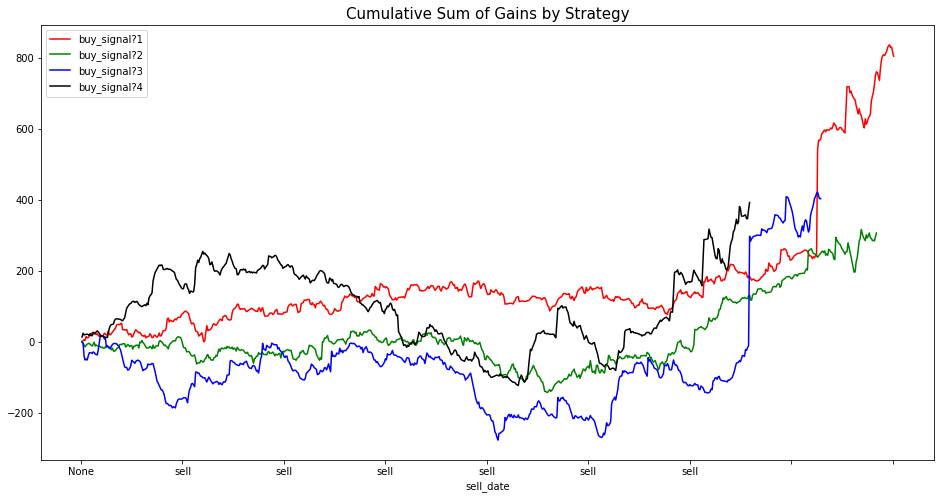

In [82]:
colors = ['red', 'green', 'blue', 'black']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(list_of_signals):
    rgl_df[rgl_df['strategy'] == signal]['$_gain'].cumsum().plot(figsize=(16,8), color=colors[idx], label=signal)

plt.legend()
plt.title('Cumulative Sum of Gains by Strategy', size=15);

### Holdings

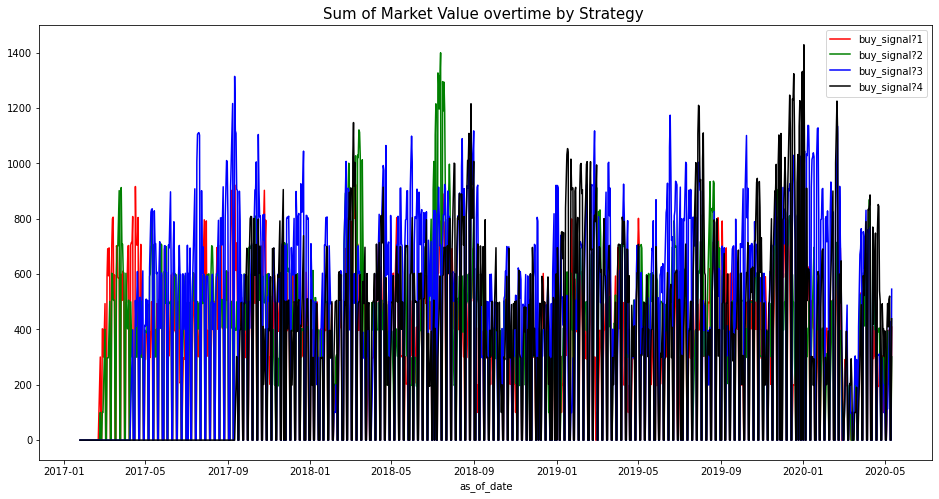

In [83]:
colors = ['red', 'green', 'blue', 'black']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(list_of_signals):
    holdings_df[holdings_df['strategy'] == signal].groupby(level=0).sum()['market_value'].plot(figsize=(16,8), color=colors[idx], label=signal)

plt.legend()
plt.title('Sum of Market Value overtime by Strategy ', size=15);


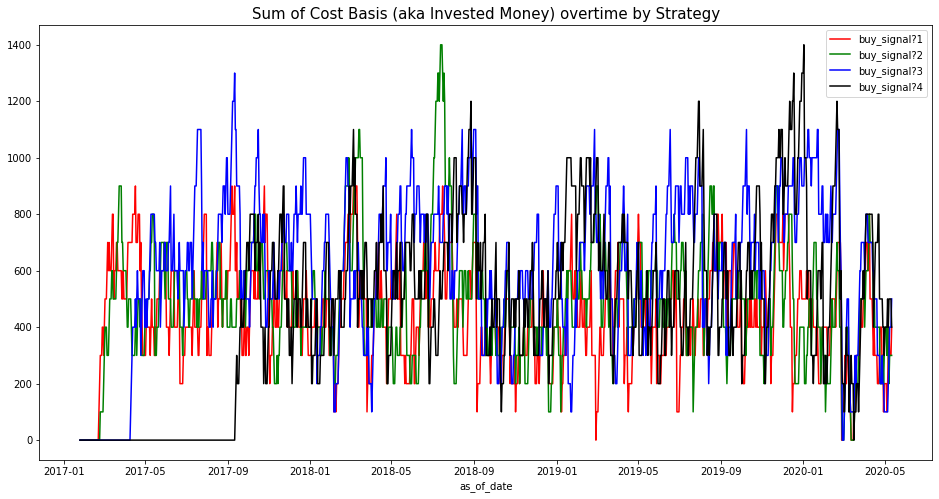

In [84]:
colors = ['red', 'green', 'blue', 'black']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(list_of_signals):
    holdings_df[holdings_df['strategy'] == signal].groupby(level=0).sum()['cost_basis'].plot(figsize=(16,8), color=colors[idx], label=signal)

plt.legend()
plt.title('Sum of Cost Basis (aka Invested Money) overtime by Strategy', size=15);